In [2]:
# DataFrame
import pandas as pd

# Matplot
import matplotlib.pyplot as plt
%matplotlib inline

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer

# Keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, Embedding, Flatten, Conv1D, MaxPooling1D, LSTM
from keras import utils
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

# Word2vec
import gensim

# Utility
import re
import string
import numpy as np
import os
from collections import Counter
import logging
import time
import pickle
import itertools

# Set log
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

Using TensorFlow backend.


In [3]:
# DATASET
DATASET_ENCODING = "ISO-8859-1"
TRAIN_SIZE = 0.8

# WORD2VEC 
W2V_SIZE = 320
W2V_WINDOW = 7
W2V_EPOCH = 32
W2V_MIN_COUNT = 10

# KERAS
SEQUENCE_LENGTH = 300
EPOCHS = 1
BATCH_SIZE = 1024

# SENTIMENT
POSITIVE = "POSITIVE"
NEGATIVE = "NEGATIVE"
NEUTRAL = "NEUTRAL"
SENTIMENT_THRESHOLDS = (0.4, 0.7)

# EXPORT
KERAS_MODEL = "model.h5"
WORD2VEC_MODEL = "model.w2v"
TOKENIZER_MODEL = "tokenizer.pkl"
ENCODER_MODEL = "encoder.pkl"

In [27]:
dataset_path = "F:\VU\Web_Data_Processing_Systems\clean_kindle_reviews.csv"
print("Open file:", dataset_path)
df = pd.read_csv(dataset_path, encoding =DATASET_ENCODING ,lineterminator='\n')
df = df.drop(columns=["Unnamed: 0"])
df = df.sample(20000)

Open file: F:\VU\Web_Data_Processing_Systems\clean_kindle_reviews.csv


In [28]:
print("Dataset size:", len(df))

Dataset size: 20000


In [29]:
df.head(10)

,asin,overall,reviewText,summary\r
664870,B00FGHYLD4,4,Love the characters! A little too tame for me....,Cute and sweet!\r
713916,B00GJ00DTS,5,"THIS BOOK WAS AMAZING!!! VERY WELL WRITTEN, PI...",LOVED THIS BOOK!!!!!\r
413126,B00B51XRTO,5,Have not tried this yet but plan to self publi...,Good reference!\r
442248,B00BKKRK20,3,This story is okay it wasn't enough informatio...,GT\r
219519,B007YX9X18,5,Definitely loved it a lot!!!!!!!! The story in...,Ari's review\r
434975,B00BGBBBB4,4,I enjoyed this story. Colleen Coble is an exce...,Good!\r
636481,B00EXTVSHI,5,Buy. This. Book. Now.What more is there to say...,Leaves You Wanting More!\r
543420,B00D68Y0V8,5,If you love suspense and adventure then you'll...,great writing with hooking suspense\r
790238,B00HUFDI8Y,5,"From reading this book, I can confidently say ...",Amazing advice!\r
389914,B00AS0EU5I,5,I'm just going to go ahead and get the biggest...,bitter sweet and really good\r


In [30]:
decode_map = {1: "NEGATIVE", 2: "NEGATIVE", 3: "NEUTRAL", 4: "POSITIVE", 5: "POSITIVE" }
def decode_sentiment(label):
    return decode_map[int(label)]

In [31]:
%%time
df.overall = df.overall.apply(lambda x: decode_sentiment(x))

Wall time: 24 ms


Text(0.5, 1.0, 'Dataset labels distribuition')

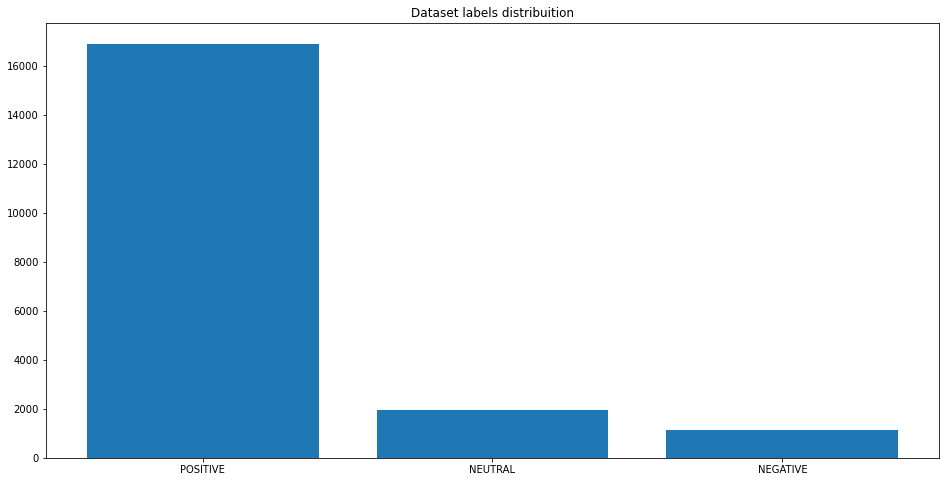

In [32]:
target_cnt = Counter(df.overall)

plt.figure(figsize=(16,8))
plt.bar(target_cnt.keys(), target_cnt.values())
plt.title("Dataset labels distribuition")

In [33]:
df.reviewText.head(10)

664870    Love the characters! A little too tame for me....
713916    THIS BOOK WAS AMAZING!!! VERY WELL WRITTEN, PI...
413126    Have not tried this yet but plan to self publi...
442248    This story is okay it wasn't enough informatio...
219519    Definitely loved it a lot!!!!!!!! The story in...
434975    I enjoyed this story. Colleen Coble is an exce...
636481    Buy. This. Book. Now.What more is there to say...
543420    If you love suspense and adventure then you'll...
790238    From reading this book, I can confidently say ...
389914    I'm just going to go ahead and get the biggest...
Name: reviewText, dtype: object

In [34]:
# split train, test data 
df_train, df_test = train_test_split(df, test_size=1-TRAIN_SIZE, random_state=42)
print("TRAIN size:", len(df_train))
print("TEST size:", len(df_test))

TRAIN size: 16000
TEST size: 4000


In [35]:
df_train.head()

,asin,overall,reviewText,summary\r
489064,B00C9FTZ5U,NEUTRAL,2.5-3 stars - An okay read. Your mileage will ...,Had some issues...\r
844534,B00IODNJRG,POSITIVE,I could not put this book down. I loved it!! ...,loved this book!!!! amazing\r
235681,B0086OEU4E,NEUTRAL,This story was very short. She works for and ...,"SHORT, CUTE\r"
320051,B009M4YYZW,POSITIVE,"I really liked this author, I had never read h...",Hot Alpha\r
544058,B00D6OE8SW,POSITIVE,Thank you kindly to the author for giving me a...,Intriguing little tale...\r


In [37]:
# tokenization
documents = [_text.split() for _text in df_train.reviewText]

In [38]:
# cleaning token
def cleaned(token):
    if token == 'u':
        return 'you'
    if token == 'r':
        return 'are'
    if token == 'some1':
        return 'someone'
    if token == 'yrs':
        return 'years'
    if token == 'hrs':
        return 'hours'
    if token == 'mins':
        return 'minutes'
    if token == 'secs':
        return 'seconds'
    if token == 'pls' or token == 'plz':
        return 'please'
    if token == '2morow' or token == '2moro':
        return 'tomorrow'
    if token == '2day':
        return 'today'
    if token == '4got' or token == '4gotten':
        return 'forget'
    if token in ['hahah', 'hahaha', 'hahahaha']:
        return 'haha'
    if token == "mother's":
        return "mother"
    if token == "mom's":
        return "mom"
    if token == "dad's":
        return "dad"
    if token == 'bday' or token == 'b-day':
        return 'birthday'
    if token in ["i'm", "don't", "can't", "couldn't", "aren't", "wouldn't", "isn't", "didn't", "hadn't",
                 "doesn't", "won't", "haven't", "wasn't", "hasn't", "shouldn't", "ain't", "they've"]:
        return token.replace("'", "")
    if token in ['lmao', 'lolz', 'rofl']:
        return 'lol'
    if token == '<3':
        return 'love'
    if token == 'thanx' or token == 'thnx':
        return 'thanks'
    if token == 'goood':
        return 'good'
    if token in ['amp', 'quot', 'lt', 'gt', '½25', '..', '. .', '. . .']:
        return ''
    return token

# processing
def process_token(tweet_tokens):

    cleaned_tokens = []

    for token in tweet_tokens:
        # Eliminating the token if it is a link
        token = re.sub(r'''(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:'".,<>?«»“”‘’]))''', " ", token)
        # Eliminating the token if it is a mention
        token = re.sub("(@[A-Za-z0-9_]+)","", token)
        # Eliminating the token if it is not characters in English
        token = re.sub("([^A-Za-z0-9_]+)","", token)
        
        cleaned_token = cleaned(token.lower())
        
        if cleaned_token == "idk":
            cleaned_tokens.append('i')
            cleaned_tokens.append('dont')
            cleaned_tokens.append('know')
            continue
        if cleaned_token == "i'll":
            cleaned_tokens.append('i')
            cleaned_tokens.append('will')
            continue
        if cleaned_token == "you'll":
            cleaned_tokens.append('you')
            cleaned_tokens.append('will')
            continue
        if cleaned_token == "we'll":
            cleaned_tokens.append('we')
            cleaned_tokens.append('will')
            continue
        if cleaned_token == "it'll":
            cleaned_tokens.append('it')
            cleaned_tokens.append('will')
            continue
        if cleaned_token == "it's":
            cleaned_tokens.append('it')
            cleaned_tokens.append('is')
            continue
        if cleaned_token == "i've":
            cleaned_tokens.append('i')
            cleaned_tokens.append('have')
            continue
        if cleaned_token == "you've":
            cleaned_tokens.append('you')
            cleaned_tokens.append('have')
            continue
        if cleaned_token == "we've":
            cleaned_tokens.append('we')
            cleaned_tokens.append('have')
            continue
        if cleaned_token == "they've":
            cleaned_tokens.append('they')
            cleaned_tokens.append('have')
            continue
        if cleaned_token == "you're":
            cleaned_tokens.append('you')
            cleaned_tokens.append('are')
            continue
        if cleaned_token == "we're":
            cleaned_tokens.append('we')
            cleaned_tokens.append('are')
            continue
        if cleaned_token == "they're":
            cleaned_tokens.append('they')
            cleaned_tokens.append('are')
            continue
        if cleaned_token == "let's":
            cleaned_tokens.append('let')
            cleaned_tokens.append('us')
            continue
        if cleaned_token == "she's":
            cleaned_tokens.append('she')
            cleaned_tokens.append('is')
            continue
        if cleaned_token == "he's":
            cleaned_tokens.append('he')
            cleaned_tokens.append('is')
            continue
        if cleaned_token == "that's":
            cleaned_tokens.append('that')
            cleaned_tokens.append('is')
            continue
        if cleaned_token == "i'd":
            cleaned_tokens.append('i')
            cleaned_tokens.append('would')
            continue
        if cleaned_token == "you'd":
            cleaned_tokens.append('you')
            cleaned_tokens.append('would')
            continue
        if cleaned_token == "there's":
            cleaned_tokens.append('there')
            cleaned_tokens.append('is')
            continue
        if cleaned_token == "what's":
            cleaned_tokens.append('what')
            cleaned_tokens.append('is')
            continue
        if cleaned_token == "how's":
            cleaned_tokens.append('how')
            cleaned_tokens.append('is')
            continue
        if cleaned_token == "who's":
            cleaned_tokens.append('who')
            cleaned_tokens.append('is')
            continue
        if cleaned_token == "y'all" or cleaned_token == "ya'll":
            cleaned_tokens.append('you')
            cleaned_tokens.append('all')
            continue

        if cleaned_token.strip() and cleaned_token not in string.punctuation: 
            cleaned_tokens.append(cleaned_token)
            
    return cleaned_tokens

In [39]:
print(documents[4])

['Thank', 'you', 'kindly', 'to', 'the', 'author', 'for', 'giving', 'me', 'a', 'copy', 'of', 'this', 'novella', 'for', 'review.When', 'branch', 'manager', 'Giles', 'Macintosh', 'arrives', 'to', 'open', 'up', 'one', 'morning', 'and', 'finds', 'an', 'injured', 'bum', 'and', 'his', 'battered', 'dog', 'lying', 'in', 'the', 'doorway', 'of', 'the', 'bank,', 'he', 'little', 'suspects', 'what', 'lies', 'in', 'store', 'for', 'them', 'all.This', 'was', 'a', 'quirky', 'and', 'intriguing', 'little', 'story', '-', 'my', 'one', 'complaint', 'is', 'that', 'I', 'would', 'have', 'liked', 'it', 'to', 'be', 'longer..it', 'felt', 'like', 'a', 'novel', 'in', 'the', 'making.', 'Thats', 'not', 'a', 'bad', 'thing', 'incidentally,', 'it', 'meant', 'that', 'I', 'would', 'happily', 'have', 'read', 'on....Its', 'a', 'bit', 'difficult', 'to', 'put', 'this', 'one', 'in', 'a', 'genre', 'box.', 'It', 'was', 'a', 'fairly', 'gritty', 'read', 'whilst', 'also', 'having', 'a', 'heart', 'warming', 'message', 'at', 'its', 'h

In [40]:
print(process_token(documents[4]))

['thank', 'you', 'kindly', 'to', 'the', 'author', 'for', 'giving', 'me', 'a', 'copy', 'of', 'this', 'novella', 'for', 'reviewwhen', 'branch', 'manager', 'giles', 'macintosh', 'arrives', 'to', 'open', 'up', 'one', 'morning', 'and', 'finds', 'an', 'injured', 'bum', 'and', 'his', 'battered', 'dog', 'lying', 'in', 'the', 'doorway', 'of', 'the', 'bank', 'he', 'little', 'suspects', 'what', 'lies', 'in', 'store', 'for', 'them', 'allthis', 'was', 'a', 'quirky', 'and', 'intriguing', 'little', 'story', 'my', 'one', 'complaint', 'is', 'that', 'i', 'would', 'have', 'liked', 'it', 'to', 'be', 'longerit', 'felt', 'like', 'a', 'novel', 'in', 'the', 'making', 'thats', 'not', 'a', 'bad', 'thing', 'incidentally', 'it', 'meant', 'that', 'i', 'would', 'happily', 'have', 'read', 'onits', 'a', 'bit', 'difficult', 'to', 'put', 'this', 'one', 'in', 'a', 'genre', 'box', 'it', 'was', 'a', 'fairly', 'gritty', 'read', 'whilst', 'also', 'having', 'a', 'heart', 'warming', 'message', 'at', 'its', 'heart', 'and', 'an

In [41]:
cleaned_documents = [process_token(document) for document in documents]

In [42]:
print(cleaned_documents[4])

['thank', 'you', 'kindly', 'to', 'the', 'author', 'for', 'giving', 'me', 'a', 'copy', 'of', 'this', 'novella', 'for', 'reviewwhen', 'branch', 'manager', 'giles', 'macintosh', 'arrives', 'to', 'open', 'up', 'one', 'morning', 'and', 'finds', 'an', 'injured', 'bum', 'and', 'his', 'battered', 'dog', 'lying', 'in', 'the', 'doorway', 'of', 'the', 'bank', 'he', 'little', 'suspects', 'what', 'lies', 'in', 'store', 'for', 'them', 'allthis', 'was', 'a', 'quirky', 'and', 'intriguing', 'little', 'story', 'my', 'one', 'complaint', 'is', 'that', 'i', 'would', 'have', 'liked', 'it', 'to', 'be', 'longerit', 'felt', 'like', 'a', 'novel', 'in', 'the', 'making', 'thats', 'not', 'a', 'bad', 'thing', 'incidentally', 'it', 'meant', 'that', 'i', 'would', 'happily', 'have', 'read', 'onits', 'a', 'bit', 'difficult', 'to', 'put', 'this', 'one', 'in', 'a', 'genre', 'box', 'it', 'was', 'a', 'fairly', 'gritty', 'read', 'whilst', 'also', 'having', 'a', 'heart', 'warming', 'message', 'at', 'its', 'heart', 'and', 'an

In [43]:
# word 2 vec
w2v_model = gensim.models.word2vec.Word2Vec(size=W2V_SIZE, 
                                            window=W2V_WINDOW, 
                                            min_count=W2V_MIN_COUNT, 
                                            workers=8)

In [44]:
w2v_model.build_vocab(documents)

2020-12-01 10:06:20,004 : INFO : collecting all words and their counts
2020-12-01 10:06:20,006 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2020-12-01 10:06:20,662 : INFO : PROGRESS: at sentence #10000, processed 1108622 words, keeping 78636 word types
2020-12-01 10:06:21,044 : INFO : collected 107612 word types from a corpus of 1773065 raw words and 16000 sentences
2020-12-01 10:06:21,046 : INFO : Loading a fresh vocabulary
2020-12-01 10:06:21,231 : INFO : effective_min_count=10 retains 9657 unique words (8% of original 107612, drops 97955)
2020-12-01 10:06:21,233 : INFO : effective_min_count=10 leaves 1601566 word corpus (90% of original 1773065, drops 171499)
2020-12-01 10:06:21,390 : INFO : deleting the raw counts dictionary of 107612 items
2020-12-01 10:06:21,399 : INFO : sample=0.001 downsamples 57 most-common words
2020-12-01 10:06:21,401 : INFO : downsampling leaves estimated 1176382 word corpus (73.5% of prior 1601566)
2020-12-01 10:06:21,547 : IN

In [45]:
words = w2v_model.wv.vocab.keys()
vocab_size = len(words)
print("Vocab size", vocab_size)

Vocab size 9657


In [ ]:
%%time
w2v_model.train(documents, total_examples=len(documents), epochs=W2V_EPOCH)

2020-12-01 10:07:35,687 : INFO : training model with 8 workers on 9657 vocabulary and 300 features, using sg=0 hs=0 sample=0.001 negative=5 window=7
2020-12-01 10:07:36,936 : INFO : EPOCH 1 - PROGRESS: at 20.03% examples, 232635 words/s, in_qsize 16, out_qsize 0
2020-12-01 10:07:37,942 : INFO : EPOCH 1 - PROGRESS: at 43.16% examples, 249782 words/s, in_qsize 15, out_qsize 0
2020-12-01 10:07:38,969 : INFO : EPOCH 1 - PROGRESS: at 65.37% examples, 252118 words/s, in_qsize 16, out_qsize 0
2020-12-01 10:07:39,975 : INFO : EPOCH 1 - PROGRESS: at 86.70% examples, 251093 words/s, in_qsize 16, out_qsize 0
2020-12-01 10:07:40,380 : INFO : worker thread finished; awaiting finish of 7 more threads
2020-12-01 10:07:40,393 : INFO : worker thread finished; awaiting finish of 6 more threads
2020-12-01 10:07:40,414 : INFO : worker thread finished; awaiting finish of 5 more threads
2020-12-01 10:07:40,424 : INFO : worker thread finished; awaiting finish of 4 more threads
2020-12-01 10:07:40,460 : INFO 

2020-12-01 10:08:06,973 : INFO : EPOCH 7 - PROGRESS: at 39.36% examples, 219412 words/s, in_qsize 15, out_qsize 0
2020-12-01 10:08:08,000 : INFO : EPOCH 7 - PROGRESS: at 60.87% examples, 229436 words/s, in_qsize 14, out_qsize 1
2020-12-01 10:08:09,022 : INFO : EPOCH 7 - PROGRESS: at 84.42% examples, 239506 words/s, in_qsize 16, out_qsize 1
2020-12-01 10:08:09,538 : INFO : worker thread finished; awaiting finish of 7 more threads
2020-12-01 10:08:09,634 : INFO : worker thread finished; awaiting finish of 6 more threads
2020-12-01 10:08:09,652 : INFO : worker thread finished; awaiting finish of 5 more threads
2020-12-01 10:08:09,655 : INFO : worker thread finished; awaiting finish of 4 more threads
2020-12-01 10:08:09,680 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-12-01 10:08:09,702 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-12-01 10:08:09,725 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-12-01 10:08:09,7

2020-12-01 10:08:37,850 : INFO : worker thread finished; awaiting finish of 7 more threads
2020-12-01 10:08:37,867 : INFO : worker thread finished; awaiting finish of 6 more threads
2020-12-01 10:08:37,871 : INFO : worker thread finished; awaiting finish of 5 more threads
2020-12-01 10:08:37,884 : INFO : worker thread finished; awaiting finish of 4 more threads
2020-12-01 10:08:37,914 : INFO : EPOCH 13 - PROGRESS: at 98.41% examples, 286585 words/s, in_qsize 3, out_qsize 1
2020-12-01 10:08:37,918 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-12-01 10:08:37,975 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-12-01 10:08:37,989 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-12-01 10:08:38,003 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-12-01 10:08:38,007 : INFO : EPOCH - 13 : training on 1773065 raw words (1176564 effective words) took 4.1s, 284934 effective words/s
2020-12-01 10:08:39,

In [22]:
w2v_model.most_similar("love")

/Users/chieh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.
2020-11-28 22:35:40,045 : INFO : precomputing L2-norms of word weight vectors


[('luv', 0.4701746702194214),
 ('loved', 0.45110470056533813),
 ('loves', 0.3913668692111969),
 ('jordin', 0.3653492331504822),
 ('respect', 0.34521371126174927),
 ('loooove', 0.3359905481338501),
 ('thankful', 0.3306002914905548),
 ('mileycyrus', 0.3299708068370819),
 ('ily', 0.32589322328567505),
 ('demi', 0.32533642649650574)]

In [23]:
# Tokenize Text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_train.TEXT)

vocab_size = len(tokenizer.word_index) + 1
print("Total words", vocab_size)

Total words 97197


In [24]:
x_train = pad_sequences(tokenizer.texts_to_sequences(df_train.TEXT), maxlen=SEQUENCE_LENGTH)
x_test = pad_sequences(tokenizer.texts_to_sequences(df_test.TEXT), maxlen=SEQUENCE_LENGTH)

In [25]:
# Label encoder
labels = df_train.VALUE.unique().tolist()
labels

['NEGATIVE', 'POSITIVE']

In [26]:
encoder = LabelEncoder()
encoder.fit(df_train.VALUE.tolist())

y_train = encoder.transform(df_train.VALUE.tolist())
y_test = encoder.transform(df_test.VALUE.tolist())

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

print("y_train",y_train.shape)
print("y_test",y_test.shape)

y_train (163982, 1)
y_test (40996, 1)


In [27]:
print("x_train", x_train.shape)
print("y_train", y_train.shape)
print("x_test", x_test.shape)
print("y_test", y_test.shape)

x_train (163982, 300)
y_train (163982, 1)
x_test (40996, 300)
y_test (40996, 1)


In [28]:
# Embedding Layer
embedding_matrix = np.zeros((vocab_size, W2V_SIZE))
for word, i in tokenizer.word_index.items():
  if word in w2v_model.wv:
    embedding_matrix[i] = w2v_model.wv[word]
print(embedding_matrix.shape)

(97197, 300)


In [29]:
embedding_layer = Embedding(vocab_size, W2V_SIZE, weights=[embedding_matrix], input_length=SEQUENCE_LENGTH, trainable=False)

In [30]:
#Build Model
model = Sequential()
model.add(embedding_layer)
model.add(Dropout(0.5))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 300, 300)          29159100  
_________________________________________________________________
dropout (Dropout)            (None, 300, 300)          0         
_________________________________________________________________
lstm (LSTM)                  (None, 100)               160400    
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 29,319,601
Trainable params: 160,501
Non-trainable params: 29,159,100
_________________________________________________________________


In [31]:
# Compile model
model.compile(loss='binary_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])

In [57]:
# Callbacks
callbacks = [ ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
              EarlyStopping(monitor='val_accuracy', min_delta=1e-4, patience=5)]

In [58]:
# Train
history = model.fit(x_train, y_train,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_split=0.1,
                    verbose=1,
                    callbacks=callbacks)

145/145 [==============================] - 1111s 8s/step - loss: 0.4811 - accuracy: 0.7627 - val_loss: 0.4646 - val_accuracy: 0.7761


In [59]:
score = model.evaluate(x_test, y_test, batch_size=BATCH_SIZE)
print()
print("ACCURACY:",score[1])
print("LOSS:",score[0])

41/41 [==============================] - 56s 1s/step - loss: 0.4540 - accuracy: 0.7806

ACCURACY: 0.7806127667427063
LOSS: 0.4539926052093506


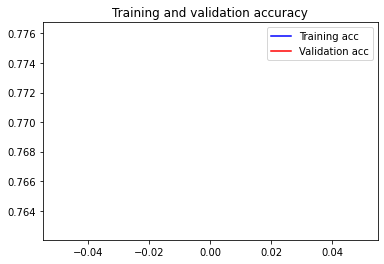

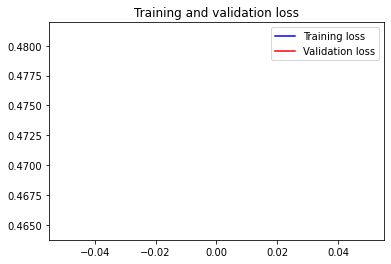

In [60]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

In [38]:
def decode_sentiment(score, include_neutral=False):
    if include_neutral:        
        label = NEUTRAL
        if score <= SENTIMENT_THRESHOLDS[0]:
            label = NEGATIVE
        elif score >= SENTIMENT_THRESHOLDS[1]:
            label = POSITIVE

        return label
    else:
        return NEGATIVE if score < 0.5 else POSITIVE

In [39]:
def predict(text, include_neutral=False):
    start_at = time.time()
    # Tokenize text
    x_test = pad_sequences(tokenizer.texts_to_sequences([text]), maxlen=SEQUENCE_LENGTH)
    # Predict
    score = model.predict([x_test])[0]
    # Decode sentiment
    label = decode_sentiment(score, include_neutral=include_neutral)

    return {"label": label, "score": float(score),
       "elapsed_time": time.time()-start_at}  

In [61]:
predict("I love the music")

{'label': 'POSITIVE',
 'score': 0.9733065366744995,
 'elapsed_time': 0.08148622512817383}

In [62]:
predict("i don't know what i'm doing")

{'label': 'NEGATIVE',
 'score': 0.4831560254096985,
 'elapsed_time': 0.07238101959228516}

In [63]:
predict("I hate the rain")

{'label': 'NEGATIVE',
 'score': 0.021119922399520874,
 'elapsed_time': 0.08184218406677246}

In [64]:
predict("Bad guys")

{'label': 'NEGATIVE',
 'score': 0.08120599389076233,
 'elapsed_time': 0.07676076889038086}

In [65]:
predict("fuck u all")

{'label': 'NEGATIVE',
 'score': 0.25452369451522827,
 'elapsed_time': 0.07674908638000488}

In [66]:
predict("I'm going under and this time I fear there's no one to save me")

{'label': 'NEGATIVE',
 'score': 0.3585672676563263,
 'elapsed_time': 0.07496809959411621}

In [45]:
#Save model
model.save(KERAS_MODEL)
w2v_model.save(WORD2VEC_MODEL)
pickle.dump(tokenizer, open(TOKENIZER_MODEL, "wb"), protocol=0)
pickle.dump(encoder, open(ENCODER_MODEL, "wb"), protocol=0)

2020-11-28 23:00:56,152 : INFO : saving Word2Vec object under model.w2v, separately None
2020-11-28 23:00:56,153 : INFO : not storing attribute vectors_norm
2020-11-28 23:00:56,154 : INFO : not storing attribute cum_table
2020-11-28 23:00:56,537 : INFO : saved model.w2v


In [67]:
model.save("model_epoc3.h5")